### นำเข้า module ของ libraries

In [1]:
# math and types libraries
import math
from math import trunc
from numpy import ndarray,array, float16, float32, float64
from numpy.typing import NDArray
from pandas import read_csv, DataFrame, to_numeric
import pandas as pd
from typing import Dict, List, Optional, Tuple, Union, Any

#preprocess scaling library
from sklearn.preprocessing import MinMaxScaler

#model library
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

#datasets split and test libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#path lib
from pathlib import Path

#seaborn
from seaborn import heatmap
from seaborn.colors.crayons import crayons

# plot graph
import matplotlib.pyplot as plt

# abstract class
from abc import ABC, abstractmethod

ประกาศชนิดข้อมูล Float

In [41]:
Float = Union[float, float16, float32, float64]

### คลาส Helper

In [ ]:

# class Helper จะมี utility methods สำหรับนำไปใช้ในส่วนอื่นๆของ modules
class Helper:
    # methods สำหรับการแปลงเลขทศนิยมเป็นค่าเปอร์เซ็น
    @staticmethod
    def convert_to_100_percent(n) -> int:
        return math.trunc(n * 100)

    # methods สำหรับการส่ง path ไฟล์ dataset ของข้อมูล
    @staticmethod
    def get_data_path() -> str:
        return "/content/data.csv"

### คลาส Module

In [ ]:

# class Module เป็น abstract class ทุก models ที่สร้างขึ้นมาจะต้องสืบทอด super class ตัวนี้นำไปใช้งาน
class Module(ABC):
    # ประกาศ attributes ทุกตัว
    description: Optional[str] = None
    model: Optional[Union[LinearRegression, DecisionTreeRegressor]] = None
    df: Optional[DataFrame] = None
    x: Optional[NDArray] = None
    y: Optional[NDArray] = None
    x_train: Optional[Any] = None
    x_test: Optional[Any] = None
    y_train: Optional[Any] = None
    y_test: Optional[Any] = None
    y_pred: Optional[ndarray] = None
    dataset_path: Optional[str] = None
    selected_cols: Optional[List[str]] = None
    cols: Tuple[str, ...] = (
        "price",
        "area",
        "bedrooms",
        "bathrooms",
        "stories",
        "mainroad",
        "guestroom",
        "basement",
        "hotwaterheating",
        "airconditioning",
        "parking",
        "prefarea",
        "furnishingstatus",
    )
    LABEL: str = "price"
    accuracy_value: Optional[Union[Float, ndarray]] = None
    error_value: Optional[Union[Float, ndarray]] = None

    
    # constructor ของ superclass เมื่อ subclass สืบทอด superclass แล้วต้องส่งค่า arg เข้ามาด้วย
    def __init__(
        self, description: Optional[str] = None, dataset_path: Optional[str] = None
    ):
        self.description = description

        # ถ้าไม่มีการส่งค่า arg ที่เป็น path ของ dataset มาให้ใช้ path เริ่มต้น
        if dataset_path == None:
            self.dataset_path = Helper.get_data_path()

    # abstract methods ของ superclass เมื่อ subclass สืบทอดไปแล้วต้องทำการ implement method เหล่านี้ทั้งหมด
    @abstractmethod
    def prepare_dataset(self):
        ...

    @abstractmethod
    def train_model(self):
        ...

    @abstractmethod
    def prediction(self):
        ...

    @abstractmethod
    def evaluate_model(self):
        ...

    # methods ของ getters
    def get_accuracy_value(self) -> Optional[Union[Float, ndarray]]:
        return self.accuracy_value
    
    def get_error_value(self) -> Optional[Union[Float, ndarray]]:
        return self.error_value
    
    # methods ของ setters
    def set_accuracy_value(self, acc_val: Union[Float, ndarray]) -> None:
        self.accuracy_value = acc_val
        
    def set_error_value(self, err_val: Union[Float, ndarray]) -> None:
        self.error_value = err_val

### คลาส DataCleaner

In [ ]:
# DataCleaner เป็น class ที่ทำหน้าที่ในการ clean ข้อมูลใน dataset ก่อนนำข้อมูลไปใช้งาน
class DataCleaner:
    df: Optional[DataFrame] = None
    scaler: MinMaxScaler = MinMaxScaler()
    is_error: bool = False
    column_names: List[str] = []
    dict_of_yes_no: Dict[str, int] = {"yes": 1, "no": 0}
    dict_of_furnishingstatus: Dict[str, int] = {
        "unfurnished": 0,
        "furnished": 1,
        "semi-furnished": 2,
    }
    
    def __init__(self) -> None:
        # อ่านค่า csv แล้วเก็บค่าลง attribute dataframe
        self.df = read_csv("/content/Housing.csv")

        # เก็บรายชื่อ columns ที่ค่าไม่ใช้ตัวเลข
        for column_name in self.df.columns:
            # เช็ค data type ของคอลัมน์ นั้นว่ามีค่าเป็น object หรือเปล่า
            if self.df[column_name].dtype == "object":
                # เพิ่มเข้าใน list
                self.column_names.append(column_name)

        # แปลงค่าคอลัมน์ที่มีค่าเป็น object(string) แปลงไปเป็นตัวเลข 1 หรือ 0 เพื่อนำ df ไปใช้งาน
        for column_name in self.column_names:
            # คอลัมน์ furnishingstatus ไม่ได้มีค่าเป็น yes, no ให้ใช้ dict อีกอัน
            if column_name == "furnishingstatus":
                self.convert_str_to_num(
                    column=column_name, keys=self.dict_of_furnishingstatus
                )
            else:
                self.convert_str_to_num(column=column_name, keys=self.dict_of_yes_no)
        # เช็คดูว่าค่าที่เป็น object แปลงเป็น int หมดแล้ว
        # print(self.df.dtypes)

    # method สำหรับคืนค่า error ถ้า True แปลว่ามีค่า error ถ้า False แปลว่าไม่มีค่า error
    def get_error(self) -> bool:
        return self.is_error

    # method สำหรับแก้ไขค่า error ส่งค่า argument เป็น boolean
    def set_error(self, val: bool) -> None:
        self.is_error = val

    # method สำหรับคืนค่า dataframe ที่ทำงานอยู่ใน class นี้
    def get_df(self) -> Optional[DataFrame]:
        return self.df

    # method สำหรับแปลงค่า string เป็นเลข
    def convert_str_to_num(self, column: str, keys: Dict[str, int]):
        # loop ทุกค่าในแต่ละ cell เปลี่ยนค่า yes = 1 และ no = 0
        for i in self.df.index:
            # นำค่าของ cell มากำหนดเป็น key ให้ dict เพื่อแปลงค่า
            key: str = self.df.loc[i, column]
            # เปลี่ยนค่าใหม่
            self.df.loc[i, column] = keys[key]
            # print(f"{key} = {self.df[column][i]}")

        # แปลงชนิดข้อมูลจาก object เป็น int
        self.df[column] = to_numeric(self.df[column])

    # method สำหรับการ normalize ข้อมูลให้ข้อมูลอยู่ในช่วง scale เดียวกัน
    def normalized(self) -> None:
        self.df = DataFrame(
            self.scaler.fit_transform(self.df), columns=self.df.columns, dtype="float16"
        )

    # method สำหรับเช็คค่าว่างของทุก cell ใน dataframe
    def check_empty_cell(self) -> None:
        # เก็บค่า booleans หากมีค่าเป็น true หมดแปลว่าใน dataframe ไม่มีค่าว่าง หากมีค่า false สักอันแปลว่า มีค่าว่าง
        bools: List[bool] = []
        # วน loop รับค่าชื่อ columns
        for column_name in self.df.columns:
            # เช็คแต่ละหัวคอลัมน์ว่ามีค่าว่างหรือเปล่า ถ้ามีค่าจะมากกว่าหรือเท่ากับ 1
            # หรือ ถ้าไม่มีค่าจะเป็น 0
            if self.df[column_name].isnull().sum() >= 1:
                # มีค่าว่างกำหนดให้ค่า error เป็นจริง
                self.set_error(True)

            # ถ้ามีค่า error จริง ให้ทำ statements นี้
            if self.get_error():
                print(f"คอลัมน์ {column_name} มีค่าว่างทำการแก้ไข")
                # สร้างค่าเฉลี่ยของแต่ล่ะคอลัมน์แต่ตัดเลขทศนิยมออก หากมี cell ที่เป็นค่าว่างให้เอาค่าเฉลี่ยเข้าไปแทนที่ cell นั้น
                mean: int = trunc(self.df[column_name].mean())
                self.df[column_name].fillna(mean, inplace=True)
                bools.append(False)
                # ขึ้นรอบใหม่ให้ค่า error เป็น False
                self.set_error(False)
            else:
                bools.append(True)

        # หากมีค่า True เท่ากับจำนวนคอลัมน์แปลว่า ไม่มีข้อมูล cell ไหนที่เป็นค่าว่าง
        self.set_error(bools.count(True) == len(self.df.columns))

        if self.get_error():
            print("ข้อมูลใน dataframe มีค่าว่าง แต่ทำการปรับปรุงแก้ไขข้อมูลที่เป็นค่าว่างแล้ว")
        else:
            print("ข้อมูลใน dataframe ไม่มีค่าว่าง")

    # method สำหรับแก้ไขรูปแบบของชนิดข้อมูล
    def check_wrong_format(self) -> None:
        if len(self.column_names) >= 1:
            self.df[self.column_names] = self.df[self.column_names].map(
                lambda x: pd.to_numeric(x)
            )
            print("เเปลงค่าเป็นตัวเลขเเล้ว")
        else:
            print("ชนิดของข้อมูลแต่ละคอลัมน์ถูกต้องแล้ว")

    # method สำหรับเช็คแถวว่ามีค่าซ้ำกันหรือไม่
    def check_duplicate_row(self) -> None:
        self.set_error(True in self.df.duplicated())
        # เช็คว่าถ้ามีค่า True ซึ่งเป็นค่าซ้ำในแถว
        if self.get_error():
            self.df.drop_duplicates(inplace=True)
            print("มีค่าซ้ำในแถวทำการลบค่าซ้ำออกจากใน dataframe")
        else:
            print("ไม่มีค่าซ้ำในแถว")

    # method สำหรับสร้างไฟล์ csv หลังจากทำ cleaning เสร็จเรียบร้อยแล้ว
    def export_to_csv(self) -> None:
        self.df.to_csv(Helper.get_data_path(), index=False)
        print("สร้างไฟล์ data.csv สำเร็จ")


### คลาส LinearRegressionModel

In [45]:

class LinearRegressionModel(Module):
    def __init__(self) -> None:
        super().__init__(
            """
            ตัว model นี้ใช้เป็น linear
            เป็น model ที่ใช้สำหรับการทำนายราคาของบ้าน
            โดยให้ x เป็นคุณสมบัติของข้อมูล คือ area
            และ y ที่เป็น class คือ price
        """
        )

    def prepare_dataset(self) -> None:
        # อ่านข้อมูลจาก dataset
        self.df = read_csv(self.dataset_path)
        # ดึง columns area กับ price
        self.x = array(self.df[["area"]])
        self.y = array(self.df[["price"]])

    def train_model(self) -> None:
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x, self.y, test_size=0.2
        )

        self.model = LinearRegression()
        self.model.fit(self.x_train, self.y_train)

    def prediction(self) -> None:
        self.y_pred = self.model.predict(self.x_test)

    def evaluate_model(self) -> None:
        self.set_accuracy_value(r2_score(self.y_test, self.y_pred))
        self.set_error_value(mean_squared_error(self.y_test, self.y_pred))

        print(f"R-squared = {Helper.convert_to_100_percent(self.get_accuracy_value())}%")
        print(f"Mean Squared Error = {self.get_error_value()}")

### คลาส MultipleRegessionModel

In [46]:
class MultipleRegessionModel(Module):
    def __init__(self):
         super().__init__(
            """
            ตัว model นี้ใช้เป็น multiple linear
            เป็น model ที่ใช้สำหรับการทำนายราคาของบ้าน
            โดยให้ x มีหลายคุณสมบัติ คือ area, bedrooms, stories, parking, mainroad,
            guestroom, hotwaterheating, airconditioning, prefarea
            และ y ที่เป็น class คือ price
        """
        )
    def prepare_dataset(self):
        self.df = read_csv(self.dataset_path)

        # ดึง columns คุณสมบัติของข้อมูล x ที่กำหนดตามเลข index
        self.selected_cols = [*self.cols[1:]]
        self.x = array(self.df[self.selected_cols].values)
        self.y = array(self.df["price"].values)

    def train_model(self) -> None:
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x, self.y, test_size=0.2, random_state=50
        )

        self.model = LinearRegression()
        self.model.fit(self.x_train, self.y_train)

    def prediction(self) -> None:
        self.y_pred = self.model.predict(self.x_test)

    def evaluate_model(self) -> None:
        self.set_accuracy_value(r2_score(self.y_test, self.y_pred))
        self.set_error_value(mean_squared_error(self.y_test, self.y_pred))

        print(f"R-squared = {Helper.convert_to_100_percent(self.get_accuracy_value())}%")
        print(f"Mean Squared Error = {self.get_error_value()}")

### คลาส PolynomialRegressionModel

In [47]:
class PolynomialRegressionModel(Module):
    poly: Optional[PolynomialFeatures] = None
    poly_linmodel: Optional[LinearRegression] = None
    x_train_poly: Optional[ndarray] = None
    x_test_poly: Optional[ndarray] = None

    def __init__(self) -> None:
        super().__init__("""
            ตัว model นี้ใช้เป็น polynomial
            เป็น model ที่ใช้สำหรับการทำนายราคาของบ้าน
            โดยให้ x มีหลายคุณสมบัติ คือ area, bedrooms, bathrooms, stories
            และ y ที่เป็น class คือ price
        """)

    def prepare_dataset(self) -> None:
        self.df = read_csv(self.dataset_path)

        self.selected_cols = [*self.cols[1:5]]
        self.x = array(self.df[self.selected_cols].values)
        self.y = array(self.df["price"])

    def train_model(self) -> None:
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x, self.y, test_size=0.2
        )

        self.poly = PolynomialFeatures(degree=3)
        self.x_train_poly = self.poly.fit_transform(self.x_train)
        self.x_test_poly = self.poly.transform(self.x_test)

        self.poly.fit(self.x_train_poly, self.y_train)

        self.poly_linmodel = LinearRegression()
        self.model = self.poly_linmodel.fit(self.x_train_poly, self.y_train)

    def prediction(self) -> None:
        self.y_pred = self.model.predict(self.x_test_poly)

    def evaluate_model(self) -> None:
        self.set_accuracy_value(r2_score(self.y_test, self.y_pred))
        self.set_error_value(mean_squared_error(self.y_test, self.y_pred))

        print(f"R-squared = {Helper.convert_to_100_percent(self.get_accuracy_value())}%")
        print(f"Mean Squared Error = {self.get_error_value()}")

### คลาาส DecisionTreeRegressionModel

In [ ]:
class DecisionTreeRegressionModel(Module):
    def __init__(self) -> None:
        super().__init__("""
            ตัว model นี้ใช้เป็น decision tree
            เป็น model ที่ใช้สำหรับการทำนายราคาของบ้าน
            โดยให้ x มี 2 คุณสมบัติ คือ area, bathrooms และ stories
            และ y ที่เป็น class คือ price
        """)

    def prepare_dataset(self) -> None:
        self.df = read_csv(self.dataset_path)
 
        self.selected_cols = ["area", "bathrooms", "stories"]
        self.x = self.df[self.selected_cols].values
        self.y = self.df["price"].values

        self.x = array(self.x)
        self.y = array(self.y)

    def train_model(self) -> None:
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x, self.y, test_size=0.2, random_state=42
        )
        self.model = DecisionTreeRegressor(random_state=42)
        self.model.fit(self.x_train, self.y_train)

    def prediction(self) -> None:
        self.y_pred = self.model.predict(self.x_test)

    def evaluate_model(self) -> None:
        self.set_accuracy_value(r2_score(self.y_test, self.y_pred))
        self.set_error_value(mean_squared_error(self.y_test, self.y_pred))

        print(f"R-squared = {Helper.convert_to_100_percent(self.get_accuracy_value())}%")
        print(f"Mean Squared Error = {self.get_error_value()}")

In [ ]:

# ถ้ายังไม่มีข้อมูล dataset ที่ยังไม่ได้ clean ให้ clean ข้อมูลก่อนรันตัว model
dataset_file: Path = Path('content/data.csv')
# ถ้าไม่มีไฟล์ data.csv ให้สร้างไฟล์ data ที่ clean ข้อมูลเรียบร้อยแล้ว
if not dataset_file.is_file():
    # สร้าง object ของ data cleaner
    cleaner: DataCleaner = DataCleaner()
    # เรียกใช้ methods จาก object เพื่อทำการ clean datset อันเก่า
    cleaner.check_empty_cell()
    cleaner.check_duplicate_row()
    cleaner.check_wrong_format()
    cleaner.normalized()
    # สร้างไฟล์ dataset อันใหม่เพื่อนำ dataset นี้ไปใช้ train model
    cleaner.export_to_csv()

# สร้าง modules ในการเก็บ regression models ของแต่ละ module
modules: Dict[str, Module] = {
    'linear_regression': LinearRegressionModel(),
    'multiple_linear_regression': MultipleRegessionModel(),
    'polynomial_regression': PolynomialRegressionModel(),
    'decision_tree_regression': DecisionTreeRegressionModel()
}

# วน loop สร้างแต่ล่ะ model
for key in modules:
  print(f'- {key.capitalize().replace("_", " ")} model')
  module = modules[key]
  module.prepare_dataset()
  module.train_model()
  module.prediction()
  module.evaluate_model()
  print()

- linear_regression model
R-squared = 28%
Mean Squared Error = 0.018227166935926385

- multiple_linear_regression model
R-squared = 75%
Mean Squared Error = 0.006369428970509594

- polynomial_regression model
R-squared = 26%
Mean Squared Error = 0.01710319591402333

- decision_tree_regression model
R-squared = 35%
Mean Squared Error = 0.02461257783145317



In [59]:
import matplotlib.pyplot as plt

# class GraphMaker สำหรับการวาดกราฟเส้น
class GraphMaker:
    # กำหนดค่า attributes ทั้งหมด
    # ใช้ค่า r-square
    accuracy_values: Optional[Union[List[float], List[ndarray]]] = None
    # ใช้ค่า error เป็น mean square error
    error_values: Optional[Union[List[float], List[ndarray]]] = None
    xlabel: str = "Regression Models"
    ylabel: str = "R Square"
    ylabel2: str = "Mean Square Error"
    model_names: List[str] = ['Linear', 'Multiple Linear', 'Polynomial', 'Decision Tree']

    # สร้าง constructor โดยมีค่า args ที่ต้องส่งคือ ค่า accuracy และ ค่า error ส่งมาเป็น list
    def __init__(
        self,
        acc_vals: Optional[Union[List[float], List[ndarray]]] = None,
        err_vals: Optional[Union[List[float], List[ndarray]]] = None,
    ) -> None:
        self.set_accuracy_values(acc_vals)
        self.set_error_values(err_vals)

    # methods สำหรับการวาดกราฟค่า accuracy (R2 score) ของ model โดยเปรียบเทียบแต่ล่ะ model
    def create_accuracy_graph(self) -> None:
        plt.plot(self.model_names, self.accuracy_values)
        plt.title("Compare the R Square values o​f each model")
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.show()

    # methods สำหรับการวาดกราฟค่า error (mean square error) ของ model โดยเปรียบเทียบแต่ล่ะ model
    def create_error_graph(self) -> None:
        plt.plot(self.model_names, self.error_values)
        plt.title("Compare the Mean Square Error values ​​of each model")
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel2)
        plt.show()

    # method สำหรับส่งค่า r square เป็น list
    def get_accuracy_values(self) -> Optional[Union[List[float], List[ndarray]]]:
        return self.accuracy_values

    # method สำหรับส่งค่า mean square error เป็น list
    def get_error_values(self) -> Optional[Union[List[float], List[ndarray]]]:
        return self.error_values

    # method สำหรับเปลี่ยน ค่า r square
    def set_accuracy_values(self, acc_vals: Union[List[float], List[ndarray]]) -> None:
        if not (acc_vals == None):
            self.accuracy_values = acc_vals

    # method สำหรับเปลี่ยนค่า error
    def set_error_values(self, err_vals: Union[List[float], List[ndarray]]) -> None:
        if not (err_vals == None):
            self.error_values = err_vals


R-squared = 32%
Mean Squared Error = 0.01622587085682189
R-squared = 75%
Mean Squared Error = 0.006369428970509594
R-squared = 4%
Mean Squared Error = 0.021150593578342432
R-squared = 35%
Mean Squared Error = 0.02461257783145317


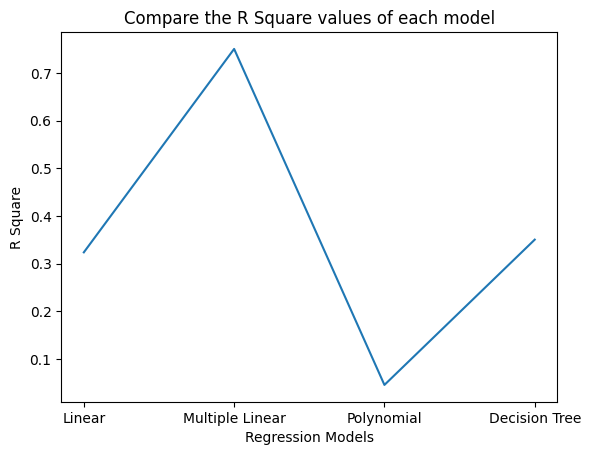

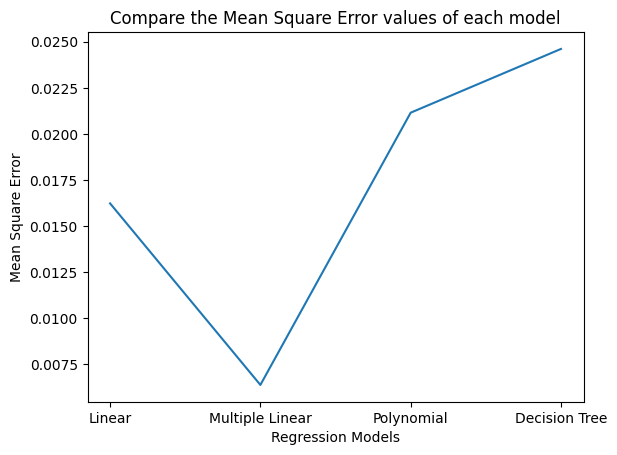

In [60]:
# นำเข้า models ทั้งหมดแต่ละ  module เก็บไว้ใน tuple
models: Tuple[Module, ...] = (
    LinearRegressionModel(),
    MultipleRegessionModel(),
    PolynomialRegressionModel(),
    DecisionTreeRegressionModel()
)

# list สำหรับเก็บค่า accuracy กับค่า error
acc_vals: List[float] = []
err_vals: List[float] = []

# วน loop รับค่า element ที่เป็น model ของแต่ล่ะตัว
for model in models:
    # เรียกใช้ method ของ model โดยให้ทำตามขั้นตอน
    model.prepare_dataset()
    model.train_model()
    model.prediction()
    model.evaluate_model()
    # เก็บค่า accuracy และ error ของแต่ล่ะ model
    acc_vals.append(model.get_accuracy_value())
    err_vals.append(model.get_error_value())

# สร้าง instance ของ GraphMaker โดยส่งค่า args ไปด้วย
maker: GraphMaker = GraphMaker(acc_vals, err_vals)
# เรียกใช้ methods สร้าง graph
maker.create_accuracy_graph()
maker.create_error_graph()

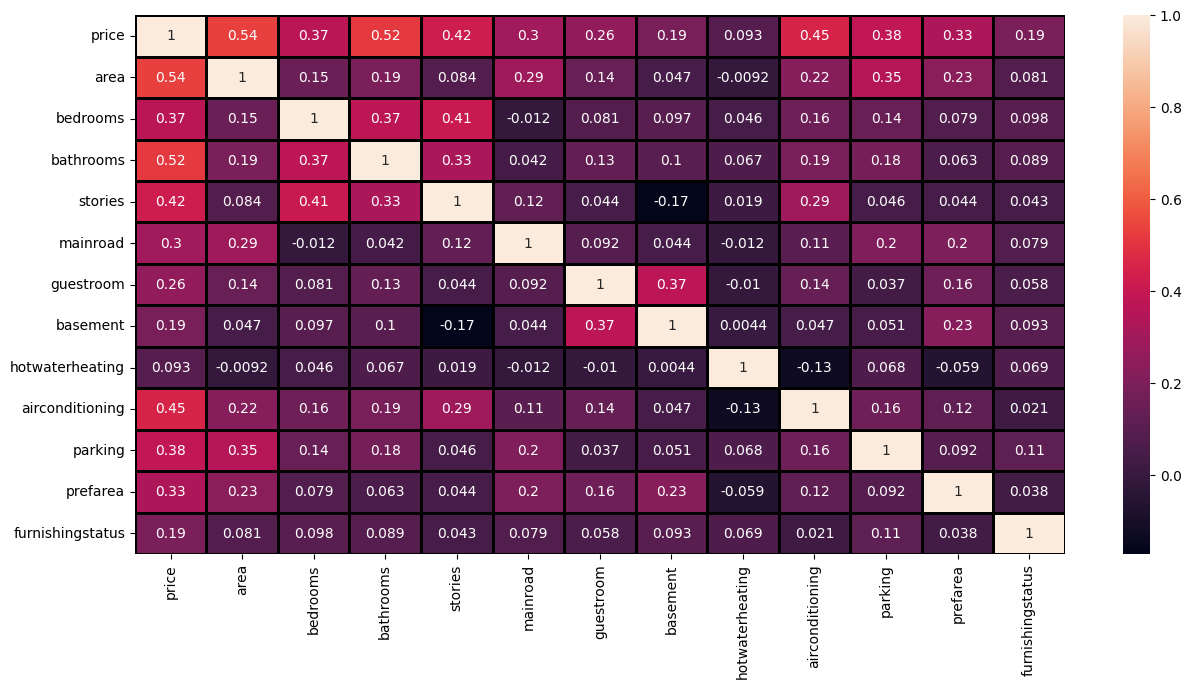

In [ ]:
# อ่านข้อมูลใน dataset
data: DataFrame = read_csv(Helper.get_data_path())

# กำหนดขนาดของกราฟ
plt.figure(figsize=(15, 7))
# สร้างกราฟความสัมพันธ์ของแต่ละคอลัมน์ใน dataset
heatmap(data.corr(), annot=True, linecolor=crayons["Black"], linewidths=2, cbar=True)
# แสดงกราฟ
plt.show()
